In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
from skimage import color
from skimage import io
import random

In [ ]:
img = io.imread("gibbon.png")
img_gray = color.rgb2gray(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


In [ ]:
img_gray_90 = np.rot90(img_gray)
img_gray_180 = np.rot90(img_gray_90)
img_gray_270 = np.rot90(img_gray_180)

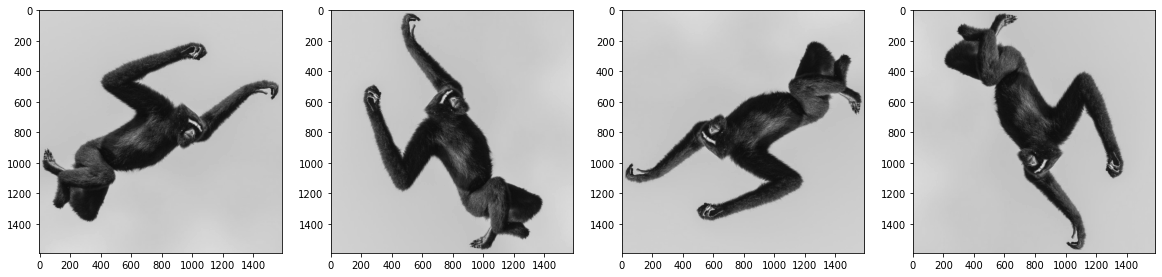

In [ ]:
rotated_imgs = [img_gray, img_gray_90, img_gray_180, img_gray_270]
f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(rotated_imgs):
  ax[i].imshow(image, cmap='gray')

plt.show()

In [ ]:
def standard_convolution(image, kernel):
  feature_map = np.zeros((image.shape[0] - kernel.shape[0] + 1,
                        image.shape[1] - kernel.shape[1] + 1))

  for r in range(image.shape[0] - kernel.shape[0]):
    for c in range(image.shape[1] - kernel.shape[1]):
      img_patch = image[r:r+kernel.shape[0], c:c+kernel.shape[1]]
      feature_map[r,c] = np.dot(img_patch.flatten(), kernel.flatten())

  return feature_map

edge_kernel = np.array([
  [1, 1, 1, 1, 1], 
  [0.5, 0.5, 0.5, 0.5, 0.5], 
  [0, 0, 0, 0, 0],
  [-0.5, -0.5, -0.5, -0.5, -0.5], 
  [-1, -1, -1, -1, -1],
])

feature_maps = [standard_convolution(image, edge_kernel) for image in rotated_imgs]

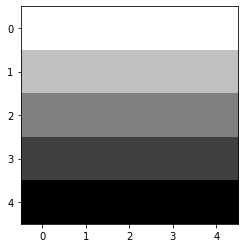

In [ ]:
plt.imshow(edge_kernel, cmap='gray')

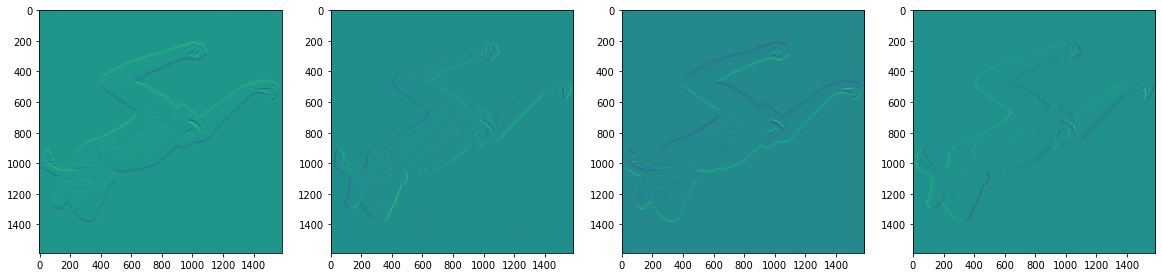

In [ ]:
aligned_feature_maps = [feature_maps[0]]

for i in range(1, len(feature_maps)):
  aligned_feature_maps.append(np.rot90(feature_maps[i],4-i))

f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(aligned_feature_maps):
  ax[i].imshow(image)

plt.show()

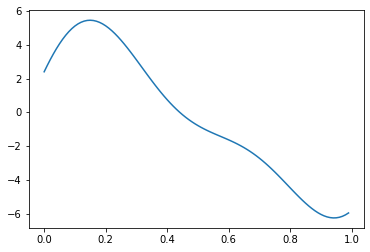

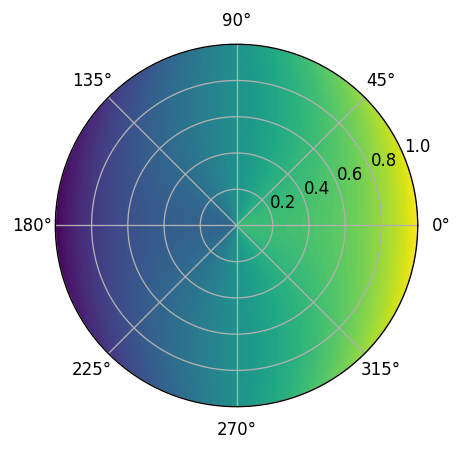

In [ ]:
coefficient_list = [[random.uniform(-5,5), random.uniform(-5,5)] for x in range(3)]
X = np.arange(0,1,0.01) 
y = [0 for x in X]

for i,val in enumerate(X):
  for j,coeff in enumerate(coefficient_list):
    y[i] += coeff[0] * np.sin((j+1) * np.pi * val)
    y[i] += coeff[1] * np.cos((j+1) * np.pi * val)


plt.plot(X,y)
# plt.show()

def T(theta):
  return np.sin(theta + np.pi/2)

def R(r):
  # total = 0

  # for i,coeff in enumerate(coefficient_list):
  #   total += coeff[0] * np.sin((i+1) * np.pi * r)
  #   total += coeff[1] * np.cos((i+1) * np.pi * r)

  # return total
  return np.e**(r**2)

rlist=np.arange(0,1.01,0.01)
thetalist = np.arange(0, 2*np.pi, np.pi/400)
rmesh, thetamesh = np.meshgrid(rlist, thetalist)


full_function = T(thetamesh)*R(rmesh)

fig,ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'))
ax.contourf(thetamesh,rmesh,full_function,100)


In [ ]:
import tensorflow as tf

In [ ]:
shape = [5,5, 1, 1]
max_order = 2
stddev=0.4
n_rings=5
name='_da_filter'

get_weights_dict(shape, max_order, std_mult=stddev, n_rings=n_rings, name='W'+name)

[[ 2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.]
 [-2. -2. -2. -2. -2.]]


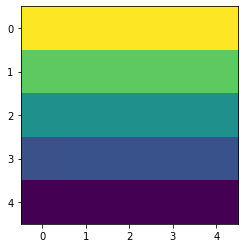

[[-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]]


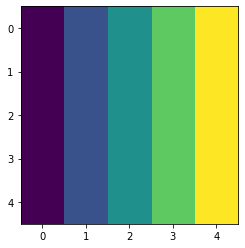

In [ ]:
def get_harmonic_value(radial_profile, kernel_size, row, column):
  x = int(column - int(kernel_size/2))
  y = int(-row + int(kernel_size/2))
  r = (x**2 + y**2)**0.5

  theta = np.angle(complex(x,y))

  magnitude = radial_profile(r)
  return [r*np.cos(theta) , r*np.sin(theta)]

def edge_profile(r):
  return np.e**(r**2)

kernel = np.array([[get_harmonic_value(edge_profile, 5, i,j) for j in range(5)] for i in range(5)])
plt.imshow(kernel[:,:,1])
print(np.array_str(kernel[:,:,1], precision=1, suppress_small=True))
plt.show()
plt.imshow(kernel[:,:,0])
print(np.array_str(kernel[:,:,0], precision=1, suppress_small=True))

In [ ]:
print(kernel[:,:,1])

In [ ]:
def generate_polar_filters(n_rings, n_angles, radial_profile, order):
  polar_filter_real = np.zeros((n_angles, n_rings))
  polar_filter_complex = np.zeros((n_angles, n_rings))

  angles = np.arange(0, 2*np.pi, 2*np.pi/n_angles)
  rings = np.arange(0+1/n_rings, 1+1/n_rings, 1/n_rings)

  for i,theta in enumerate(angles):
    for j,r in enumerate(rings):
      polar_filter_real[i,j] = radial_profile(r) * np.cos(order * theta)
      polar_filter_complex[i,j] = radial_profile(r) * np.sin(order * theta)

  return polar_filter_real, polar_filter_complex

polar_real, polar_complex = generate_polar_filters(5, 12, lambda r: np.e**(r**2), 1)  
print(np.array_str(polar_real, precision=1, suppress_small=True))

[[ 1.   1.2  1.4  1.9  2.7]
 [ 0.9  1.   1.2  1.6  2.4]
 [ 0.5  0.6  0.7  0.9  1.4]
 [ 0.   0.   0.   0.   0. ]
 [-0.5 -0.6 -0.7 -0.9 -1.4]
 [-0.9 -1.  -1.2 -1.6 -2.4]
 [-1.  -1.2 -1.4 -1.9 -2.7]
 [-0.9 -1.  -1.2 -1.6 -2.4]
 [-0.5 -0.6 -0.7 -0.9 -1.4]
 [-0.  -0.  -0.  -0.  -0. ]
 [ 0.5  0.6  0.7  0.9  1.4]
 [ 0.9  1.   1.2  1.6  2.4]]


[[-3.7 -2.4 -0.   2.4  3.7]
 [-4.9 -3.4 -0.   3.4  4.9]
 [-5.5 -3.9 -0.   3.9  5.5]
 [-4.9 -3.4 -0.   3.4  4.9]
 [-3.7 -2.4 -0.   2.4  3.7]]


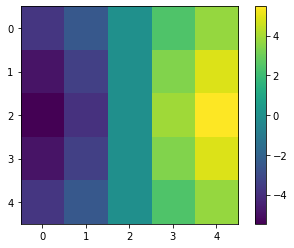

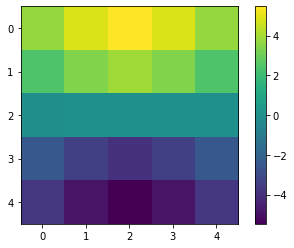

In [ ]:
def polar_coord_distance(r1, theta1, r2, theta2):
  return (r1**2 + r2**2 - 2*r1*r2*np.cos(theta1-theta2))**0.5

def generate_kernel(kernel_size, real_filter, complex_filter, stdv):
  real_kernel = np.zeros((kernel_size, kernel_size))
  complex_kernel = np.zeros((kernel_size, kernel_size)) 

  angle_iter = 2*np.pi / real_filter.shape[0] 
  radius_iter = 1 / real_filter.shape[1]

  for row in range(kernel_size):
    for column in range(kernel_size):

      pixel_x = (column - int(kernel_size/2))/2
      pixel_y = (-1*row + int(kernel_size/2))/2

      pixel_radius = (pixel_x**2 + pixel_y**2)**0.5  
      pixel_angle = np.angle(complex(pixel_x, pixel_y))
        
      real_pixel_value = 0
      complex_pixel_value = 0

      for angle,radii in enumerate(real_filter):
        polar_angle = angle*angle_iter

        for radius_index, polar_value in enumerate(radii):
          polar_radius = (radius_index + 1) * radius_iter

          distance = polar_coord_distance(pixel_radius, pixel_angle, polar_radius, polar_angle) 
          g_term = np.e**(-distance / (2*(stdv**2)))

          real_pixel_value += g_term * polar_value

      for angle,radii in enumerate(complex_filter):
        polar_angle = angle*angle_iter

        for radius_index, polar_value in enumerate(radii):
          polar_radius = (radius_index + 1) * radius_iter

          distance = polar_coord_distance(pixel_radius, pixel_angle, polar_radius, polar_angle) 
          g_term = np.e**(-distance / (2*(stdv**2)))
          # g_term = np.e**(-distance**2)

          complex_pixel_value += g_term * polar_value

      real_kernel[row,column] = real_pixel_value      
      complex_kernel[row,column] = complex_pixel_value      

  return real_kernel, complex_kernel 

r_kernel, c_kernel = generate_kernel(5, polar_real, polar_complex, 1.5)
print(np.array_str(r_kernel, precision=1, suppress_small=True))

fig, ax = plt.subplots()
shw = ax.imshow(r_kernel)
bar = plt.colorbar(shw)
plt.show()

fig, ax = plt.subplots()
shw = ax.imshow(c_kernel)
bar = plt.colorbar(shw)
plt.show()

In [ ]:
def generate_feature_map(real_kernel, complex_kernel, image):
  real_feature_map = np.zeros((img_gray.shape[0] - real_kernel.shape[0] + 1,
                          img_gray.shape[1] - real_kernel.shape[1] + 1))

  complex_feature_map = np.zeros((img_gray.shape[0] - real_kernel.shape[0] + 1,
                          img_gray.shape[1] - real_kernel.shape[1] + 1))
  
  for r in range(img_gray.shape[0] - real_kernel.shape[0]):
    for c in range(img_gray.shape[1] - real_kernel.shape[1]):
      img_patch = img_gray[r:r+real_kernel.shape[0], c:c+real_kernel.shape[1]]

      real_feature_map[r,c] = np.dot(img_patch.flatten(), real_kernel.flatten())
      complex_feature_map[r,c] = np.dot(img_patch.flatten(), complex_kernel.flatten())
  
  # real_feature_map = real_feature_map * (real_feature_map > 0)
  # complex_feature_map = complex_feature_map * (complex_feature_map > 0)
  return real_feature_map, complex_feature_map

real_map, complex_map = generate_feature_map(r_kernel, c_kernel, img_gray)

plt.imshow((real_map > 0))

KeyboardInterrupt: ignored

In [ ]:
plt.imshow((complex_map > 0))

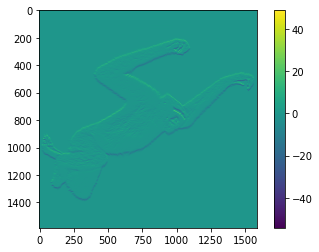

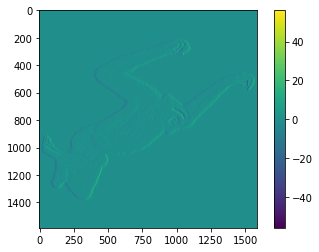

In [ ]:
fig, ax = plt.subplots()
shw = ax.imshow(complex_map)
bar = plt.colorbar(shw)
plt.show()
fig, ax = plt.subplots()
shw = ax.imshow(real_map)
bar = plt.colorbar(shw)
plt.show()

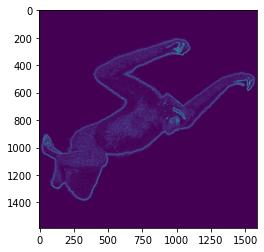

In [ ]:
new_map = np.zeros(real_map.shape)

for i in range(real_map.shape[0]):
  for j in range(real_map.shape[1]):
    magnitude = (real_map[i,j]**2 + complex_map[i,j]**2)**0.5 
    # magnitude = np.angle(complex(real_map[i,j], complex_map[i,j])) 
    new_map[i,j] = magnitude

plt.imshow(new_map)